In [50]:
import numpy as np
import pandas as pd
from scipy import stats
from iaf.plot import plot_data, add_fit
from iaf.fit.models import exponential_model
import matplotlib.pyplot as plt
from scipy import optimize

# Import the Data

In [51]:
# This df represents the mean ki67 intensity for individual nuclei (size 8261 x 3)
df = pd.read_csv('ki67_intensity_results_new.csv') 

# Group by 'well' and calculate the mean Ki-67 intensity for each well
result_df = df.groupby('Well')['Mean_Ki67_Intensity'].mean().reset_index()
result_df

,Well,Mean_Ki67_Intensity
0,0,2934.019291
1,1,3304.489858
2,2,3894.914826
3,3,4146.224642
4,4,4890.969609
5,5,4866.417082
6,6,5588.713514
7,7,5449.881483
8,8,3144.798976
9,9,4241.213607


In [52]:
# Extract the "Mean_Ki67_Intensity" column and convert it to a NumPy array
mean_ki67_intensity = result_df['Mean_Ki67_Intensity'].to_numpy()

# Reshape the array to size (5, 8)
y = mean_ki67_intensity.reshape(5, 8)
y

array([[2934.01929109, 3304.48985845, 3894.91482597, 4146.22464208,
        4890.96960871, 4866.41708203, 5588.71351401, 5449.88148314],
       [3144.79897633, 4241.21360685, 4187.36705642, 3681.24097315,
        4723.41946412, 4309.46783117, 4637.19188879, 4754.69998752],
       [2301.83657482, 3880.21561184, 3670.92353521, 3809.32978892,
        4053.52942305, 4258.09233862, 4400.64142118, 4833.81472631],
       [2531.73610857, 3366.33032708, 3992.30384   , 4286.45242445,
        4454.87979917, 5159.92046728, 4157.16800887, 5319.21047794],
       [1974.43318611, 3696.76118552, 3613.50969283, 3579.70609007,
        4618.95898509, 4878.50087296, 4713.18910845, 5294.1389475 ]])

# Data Visualization

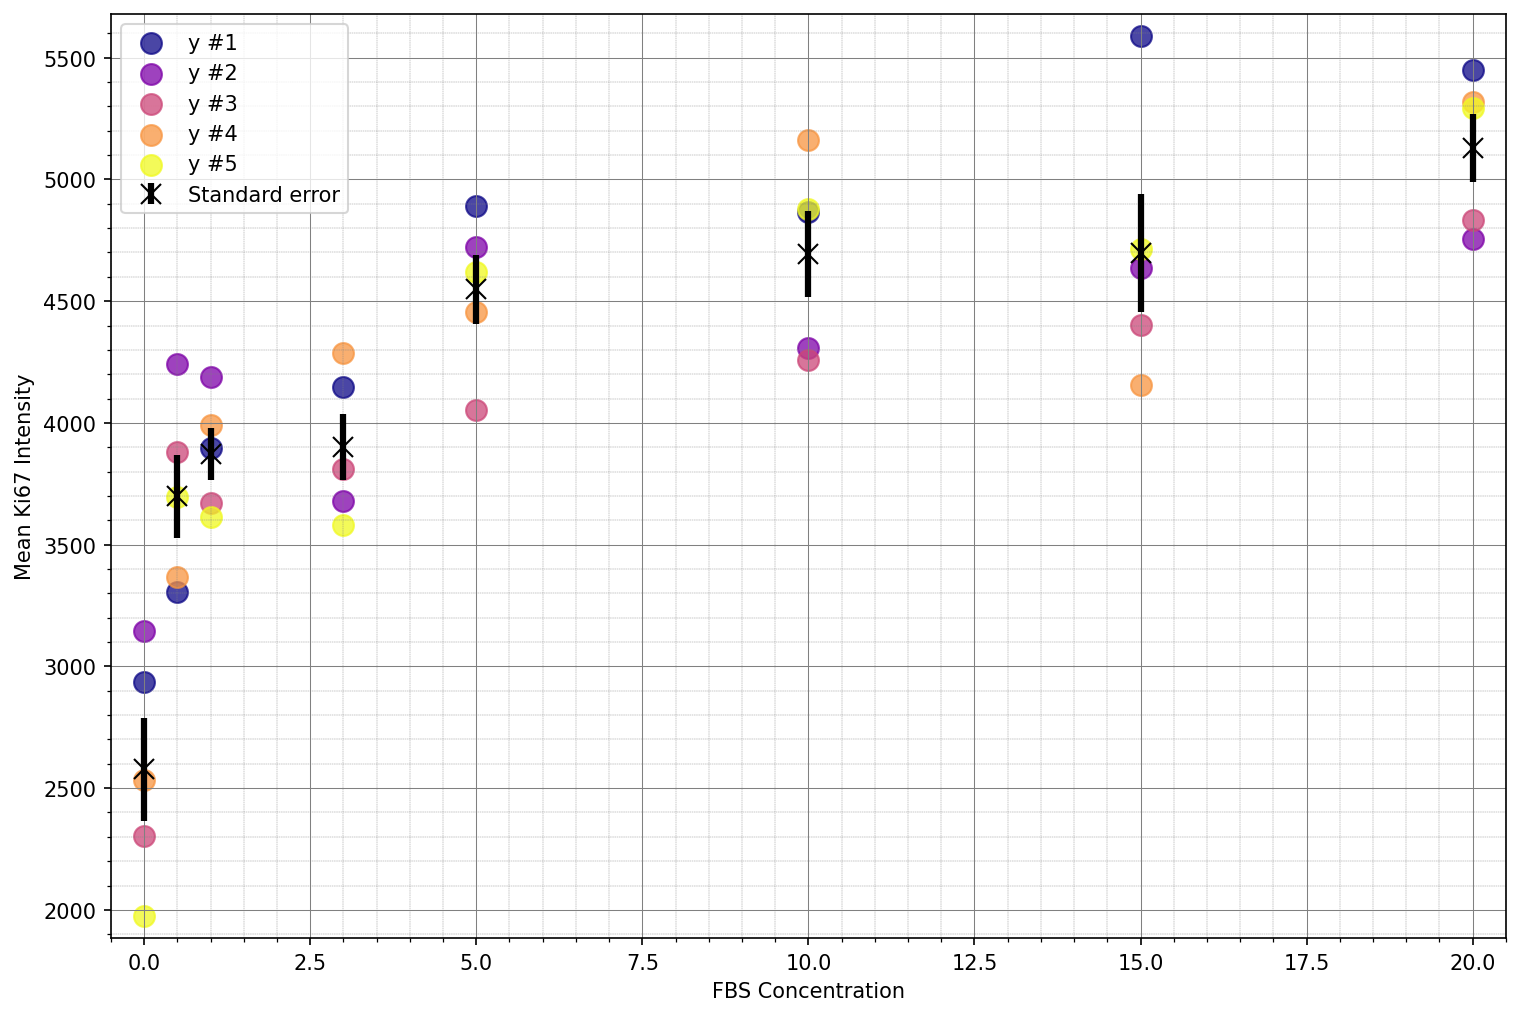

In [53]:
# Extract the data from the data frame
x=np.array([0.0, 0.5, 1.0, 3.0, 5.0, 10.0, 15.0, 20.0]) # FBS concentrations will be plotted as x values
xx = np.repeat(np.reshape(x, (1, len(x))), 5, axis=0)

# Calculate the standard error of the mean (SEM)
se = stats.sem(y)

y_mean = y.mean(axis=0)

# Call your custom plotting function
_ = plot_data(xx, y, errors=se, errors_label="Standard error")

# Add labels for x-axis and y-axis
plt.xlabel('FBS Concentration')
plt.ylabel('Mean Ki67 Intensity')

# Show the plot
plt.show()

**Observation.** With increasing FBS concentrations, we should expect the mean Ki67 intensity to start stabilizing after a certain FBS concentration. According to our data, this does not seem to be the case as the data points keep growing with increasing FBS concentrations.

# Model Fitting
Let's use 4 different models (linear, exponential, logarithmic, and square root) to fit our data and analyze which one is the best. For each model, the data will be fitted using the standard errors of the mean as weights.

## Linear Model

In [54]:
# Define the linear model
def linear_model(x, a, b):
    y_hat = a * x + b
    return y_hat

# Function that calculates the sum of squared errors between the real vs predicted data
def calc_sse(y, y_hat, se):
    weighted_sse = np.sum(np.power(y_hat - y, 2) / np.power(se, 2))
    unweighted_sse = np.sum((y_hat - y) ** 2)
    return weighted_sse, unweighted_sse

# Function that calculates the weighted sum of squared error
def objf(params, x, y, se):
    a = params[0]
    b = params[1]
    y_hat = linear_model(x, a, b)
    weighted_sse, unweighted_sse = calc_sse(y_hat, y, se)
    return weighted_sse

In [55]:
starting_values = (0.0, 0.0)

res_reps_weighed = optimize.fmin(objf, starting_values, args=(x, y_mean, se))

Optimization terminated successfully.
         Current function value: 42.374561
         Iterations: 130
         Function evaluations: 251


In [56]:
a_est_weighed = res_reps_weighed[0]
b_est_weighed = res_reps_weighed[1]

print(f"Estimated parameters (using weights): (slope = {a_est_weighed:.4f}, intercept = {b_est_weighed:.4f}).")

Estimated parameters (using weights): (slope = 78.5410, intercept = 3696.8732).


In [57]:
y_hat_weighed = linear_model(x, a_est_weighed, b_est_weighed)
linear_weighted_sse, linear_unweighted_sse = calc_sse(y_hat_weighed, y_mean, se)

print(f"Weighted SSE with linear model: {linear_weighted_sse:.4f}")
print(f"Unweighted SSE with linear model: {linear_unweighted_sse:.4f}")

Weighted SSE with linear model: 42.3746
Unweighted SSE with linear model: 1570279.6126


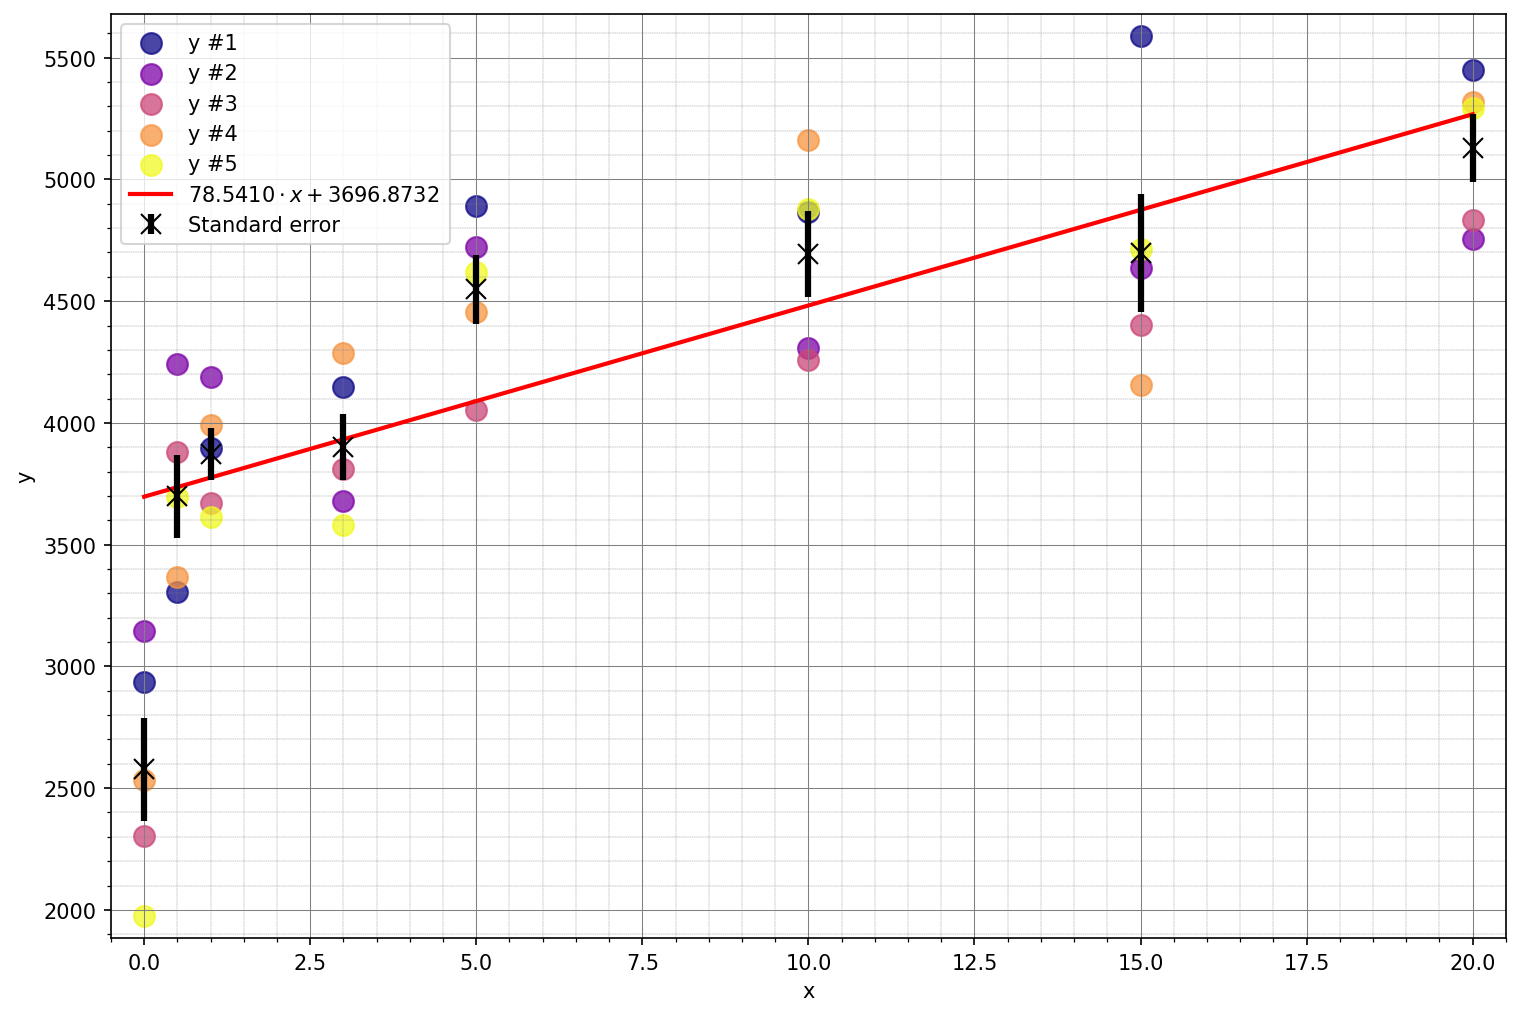

In [58]:
fig, ax = plot_data(x, y, x2=x, y_hat=y_hat_weighed, a=a_est_weighed, b=b_est_weighed, errors=se, errors_label="Standard error")

## Exponential Model

In [59]:
# Define the exponential model
def exponential_model(x, a, b):
    y_hat = a * np.exp(b * x)
    return y_hat

# Redefine the objective function
def objf_weighed(params, x, y, se):
    a = params[0]
    b = params[1]
    y_hat = exponential_model(x, a, b)
    weighted_sse, unweighted_sse = calc_sse(y_hat, y, se)
    return weighted_sse

In [60]:
starting_values =[y[0][0], 0]
res_reps_weighed = optimize.fmin(objf_weighed, starting_values, args=(x, y_mean, se))

Optimization terminated successfully.
         Current function value: 45.447567
         Iterations: 81
         Function evaluations: 153


In [61]:
a_est_weighed = res_reps_weighed[0]
b_est_weighed = res_reps_weighed[1]

print(f"Estimated parameters (using weights): (slope = {a_est_weighed:.4f}, intercept = {b_est_weighed:.4f}).")

Estimated parameters (using weights): (slope = 3735.3260, intercept = 0.0171).


In [62]:
y_hat_weighed = exponential_model(x, a_est_weighed, b_est_weighed)
exponential_weighted_sse, exponential_unweighted_sse = calc_sse(y_hat_weighed, y_mean, se)

print(f"Weighted SSE with exponential model: {exponential_weighted_sse:.4f}")
print(f"Unweighted SSE with exponential model: {exponential_unweighted_sse:.4f}")

Weighted SSE with exponential model: 45.4476
Unweighted SSE with exponential model: 1683743.4261


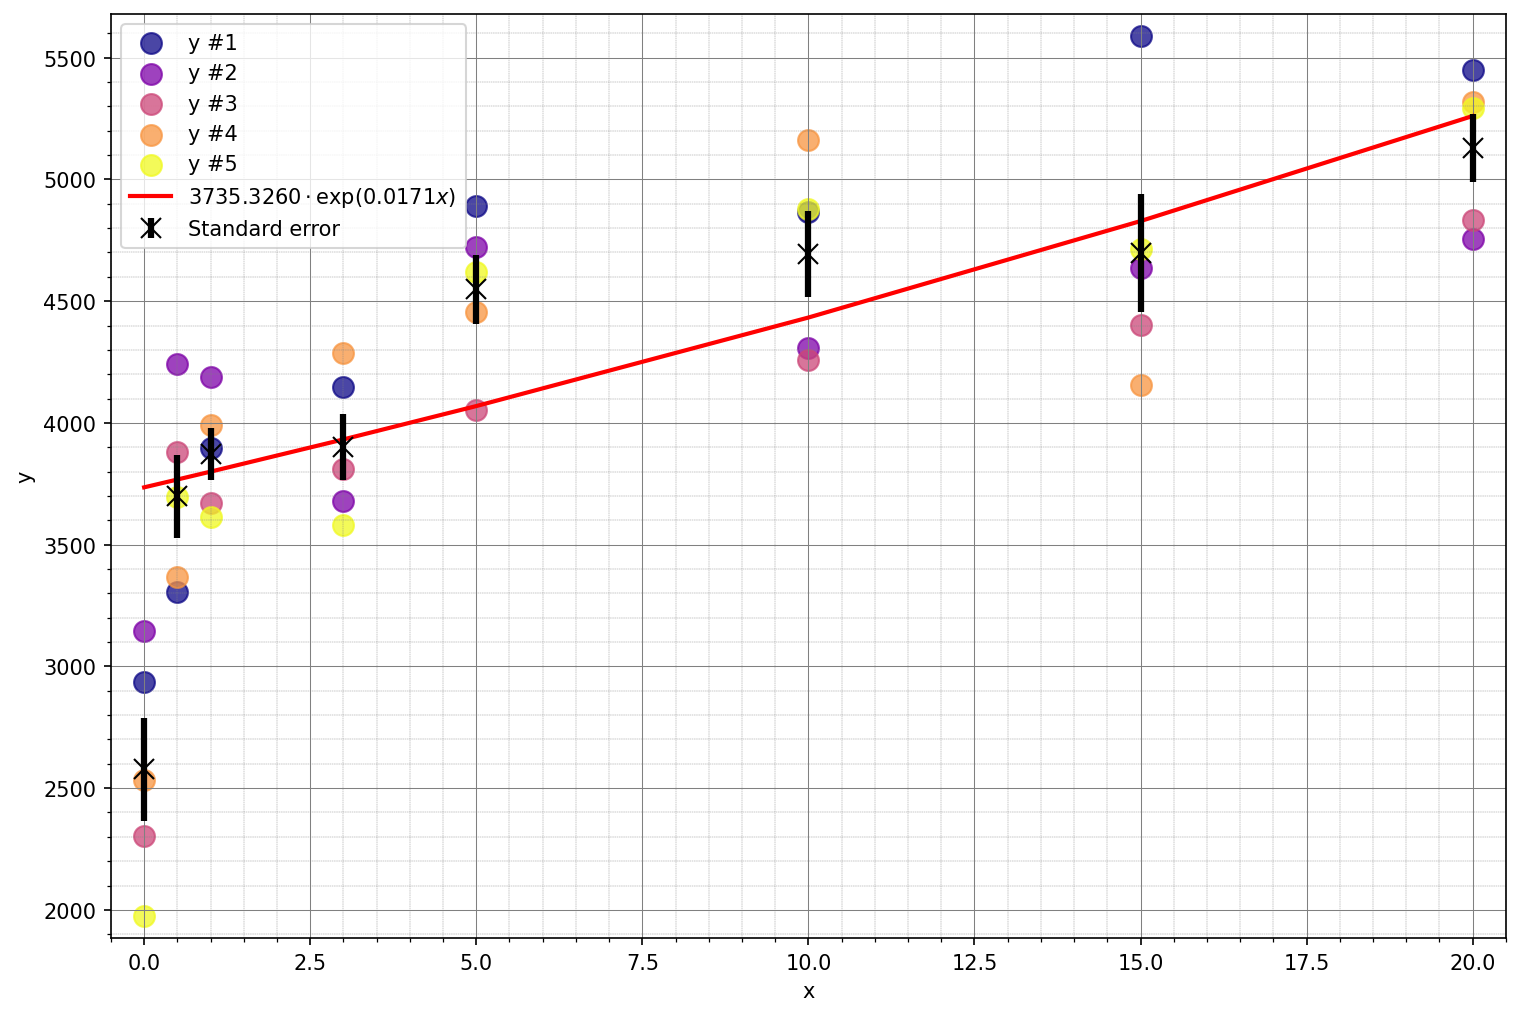

In [63]:
fig, ax = plot_data(x, y, x2=x, y_hat=y_hat_weighed, a=a_est_weighed, b=b_est_weighed, errors=se, errors_label="Standard error", model_for_legend='exp')

## Logarithmic Model

In [64]:
def logarithmic_model(x, a, b):
    y_hat = a + b * np.log(x+0.00001)
    return y_hat

def objf_weighed(params, x, y, se):
    """Our objective function (that calls the weighed version of calc_sse())."""
    a = params[0]
    b = params[1]
    y_hat = logarithmic_model(x, a, b)
    weighted_sse, unweighted_sse = calc_sse(y_hat, y, se)
    return weighted_sse

In [65]:
starting_values =[y[0][0], 1.0]
res_reps_weighed = optimize.fmin(objf_weighed, starting_values, args=(x, y_mean, se))

Optimization terminated successfully.
         Current function value: 36.635593
         Iterations: 86
         Function evaluations: 162


In [66]:
a_est_weighed = res_reps_weighed[0]
b_est_weighed = res_reps_weighed[1]

print(f"Estimated parameters (using weights): (slope = {a_est_weighed:.4f}, intercept = {b_est_weighed:.4f}).")

Estimated parameters (using weights): (slope = 4108.9306, intercept = 166.1340).


In [67]:
# Calculate weighted and unweighted SSE
y_hat_weighed = logarithmic_model(x, a_est_weighed, b_est_weighed)
logarithmic_weighted_sse, logarithmic_unweighted_sse = calc_sse(y_hat_weighed, y_mean, se)

print(f"Weighted SSE with logarithmic model: {logarithmic_weighted_sse:.4f}")
print(f"Unweighted SSE with logarithmic model: {logarithmic_unweighted_sse:.4f}")

Weighted SSE with logarithmic model: 36.6356
Unweighted SSE with logarithmic model: 806709.5793


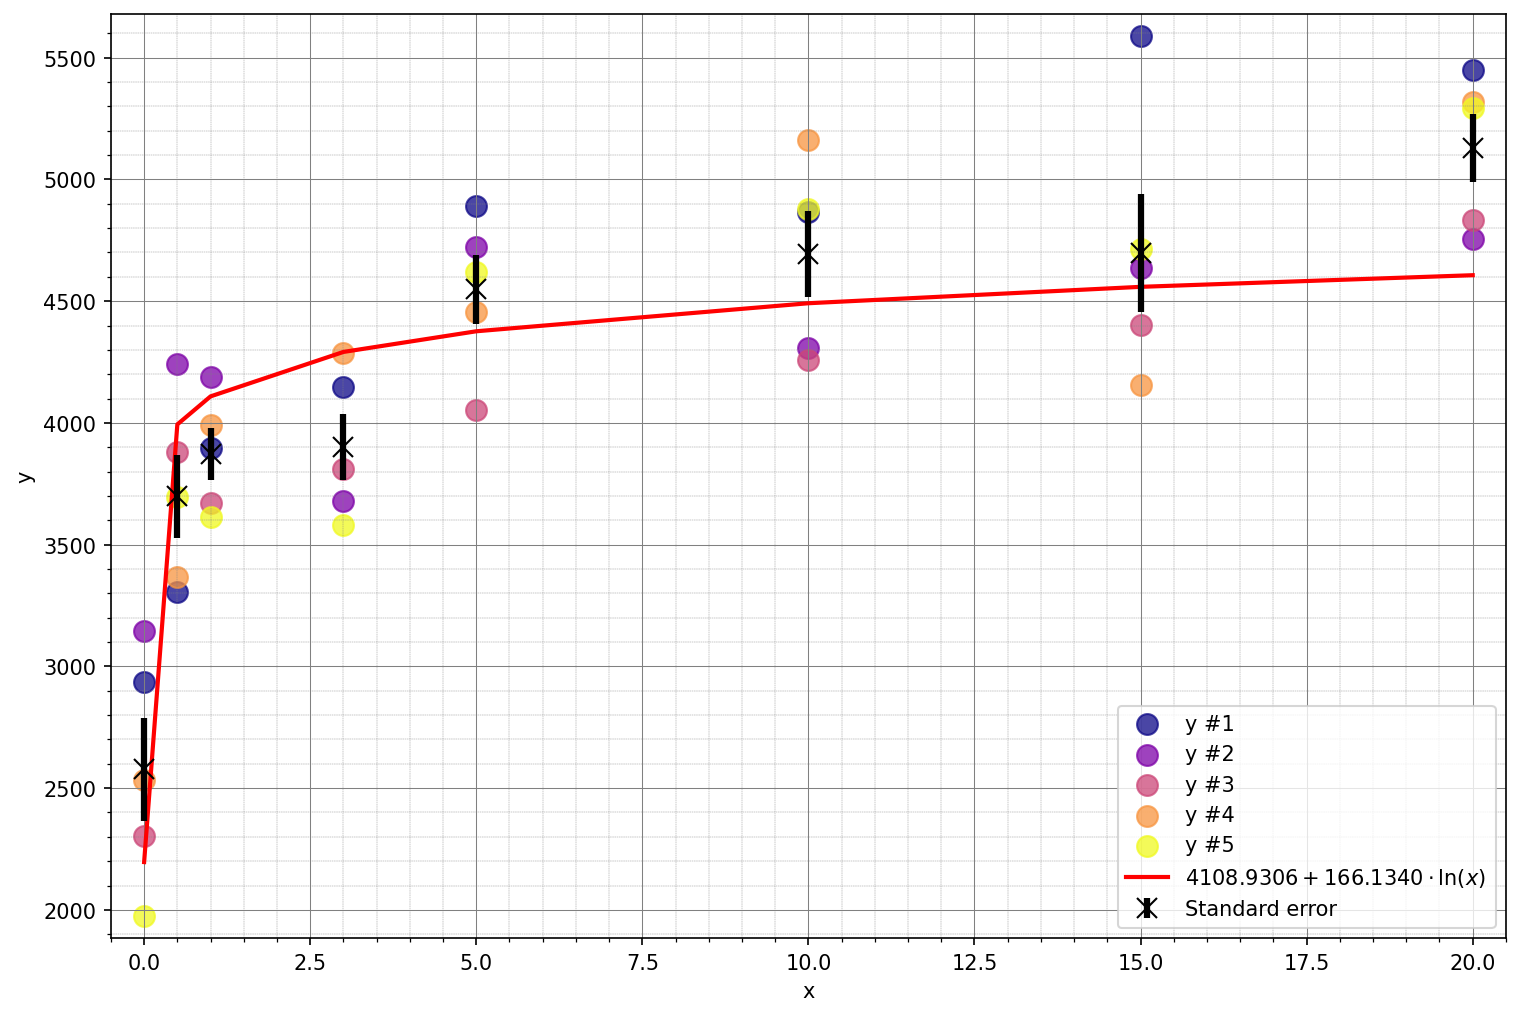

In [68]:
fig, ax = plot_data(x, y, x2=x, y_hat=y_hat_weighed, a=a_est_weighed, b=b_est_weighed, errors=se, errors_label="Standard error", model_for_legend='log')

## Square Root Model

In [69]:
def square_root_model(x, a, b):
    y_hat = a + b * np.sqrt(x)
    return y_hat

def objf_weighed(params, x, y, se):
    a = params[0]
    b = params[1]
    y_hat = square_root_model(x, a, b)
    weighted_sse, unweighted_sse = calc_sse(y_hat, y, se)
    return weighted_sse

In [70]:
starting_values =[y[0][0], 1.0]
res_reps_weighed = optimize.fmin(objf_weighed, starting_values, args=(x, y_mean, se))

Optimization terminated successfully.
         Current function value: 20.666827
         Iterations: 91
         Function evaluations: 170


In [71]:
a_est_weighed = res_reps_weighed[0]
b_est_weighed = res_reps_weighed[1]

print(f"Estimated parameters (using weights): (slope = {a_est_weighed:.4f}, intercept = {b_est_weighed:.4f}).")

Estimated parameters (using weights): (slope = 3286.9301, intercept = 433.4841).


In [72]:
# After fitting the square root model, calculate both weighted and unweighted SSE
y_hat_weighed = square_root_model(x, a_est_weighed, b_est_weighed)
sr_weighted_sse, sr_unweighted_sse = calc_sse(y_hat_weighed, y_mean, se)

print(f"Weighted SSE with square root model: {sr_weighted_sse:.4f}")
print(f"Unweighted SSE with square root model: {sr_unweighted_sse:.4f}")

Weighted SSE with square root model: 20.6668
Unweighted SSE with square root model: 722830.7038


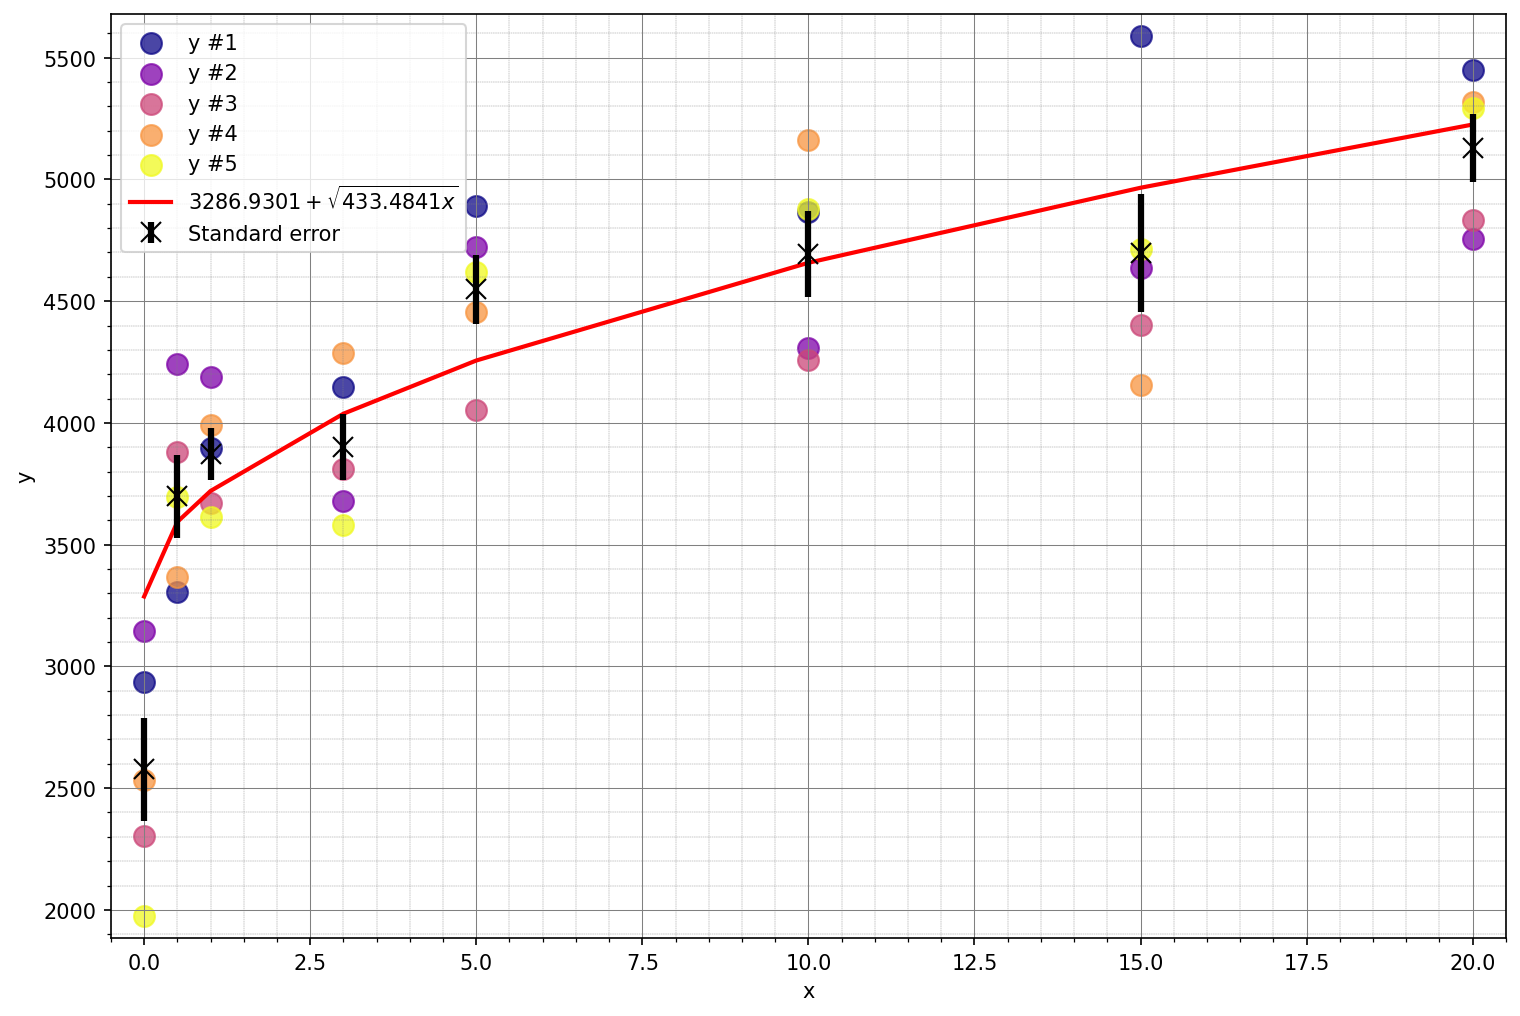

In [73]:
fig, ax = plot_data(x, y, x2=x, y_hat=y_hat_weighed, a=a_est_weighed, b=b_est_weighed, errors=se, errors_label="Standard error", model_for_legend='sqrt')

Based on the results obtained, it is clear to say that using weighted or unweighted SSEs can significantly impact the evaluation of the model's fit. In all four models, we can see that the weighted SSE of one specific model is lower than its unweighted SSE. This suggests that taking into consideration the standard errors is important and has a positive impact on the model fit. In general, using weighted SSE is recommended when the data has significant variations in standard errors. 

The square root model appears to be the best fit among the models tested. It has the lowest SSE, both weighted and unweighted, which suggests that it provides a better fit to the data compared to the other models.
The SSE values for all models indicate that the relationship between FBS concentration and the mean Ki67 intensity is not linear. The square root model might capture the underlying pattern better, but it's still not necessarily a perfect fit.

The absence of a plateau suggests that the relationship between FBS concentration and U2OS cell proliferation may not be as straightforward as expected.
If the data showed a clear plateau in Ki67 concentration at 10% FBS, it would be reasonable to consider 10% FBS as the optimal concentration for growing U2OS cells. This would suggest that beyond 10% FBS, increasing the concentration does not result in a further increase in cell proliferation, making 10% FBS the most effective concentration for promoting cell growth while minimizing the use of resources. However, in this analysis, no conclusions can be taken regarding the optimal concentration. Perhaps additional experiments or more sophisticated models could provide a better understanding of this relationship.